In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Library for data cleaning 
import statsmodels.api as sm
import scipy  # Corrected import
import scipy.stats as stats

# Library for imputation 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import HuberRegressor
import sklearn

# Store and print library versions
library_versions = {
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "matplotlib": plt.matplotlib.__version__,
    "seaborn": sns.__version__,
    "statsmodels": sm.__version__,
    "scipy": scipy.__version__,  
    "sklearn": sklearn.__version__
}

# Print library versions
for lib, version in library_versions.items():
    print(f"{lib}: {version}")

# Check scikit-learn version
print(f"scikit-learn version: {sklearn.__version__}")


scikit-learn version: 1.3.0
pandas: 1.4.4
numpy: 1.24.3
matplotlib: 3.7.2
seaborn: 0.12.2
statsmodels: 0.14.0
scipy: 1.11.1
sklearn: 1.3.0


In [2]:
# import file

file = r'E:/1 PROJECT/RESEARCH PROJECTS/HTJ res/influenza/Data/csv_work180224.xlsx'
df = pd.read_excel(file)

In [3]:
# descriptive statistics prior to data preprocessing
# stats summary for continous variables (Pre-cleaning)
selected_columns = df.iloc[:, 85:101]

# Calculate percentiles, lower, upper bounds, 0.01th, and 99.98th percentiles
percentiles_ori = selected_columns.describe(percentiles=[0.25, 0.5, 0.75, 0.01, 0.998]).transpose()

# Calculate lower and upper bounds
IQR = percentiles_ori['75%'] - percentiles_ori['25%']
lower_bound = percentiles_ori['25%'] - 1.5 * IQR
upper_bound = percentiles_ori['75%'] + 1.5 * IQR

# Add lower and upper bounds to the percentiles DataFrame
percentiles_ori['lower_bound'] = lower_bound
percentiles_ori['upper_bound'] = upper_bound

# Display the result
print("Stats Summary with Percentiles, Lower, Upper Bounds, 0.01th, and 99.8th Percentiles:")
print(percentiles_ori)

Stats Summary with Percentiles, Lower, Upper Bounds, 0.01th, and 99.8th Percentiles:
                         count        mean         std        min         1%  \
DayofillnessOseltamivir  179.0    4.960894    2.711530   1.000000   1.000000   
Age(Years)               299.0    3.521354    3.016977   0.016438   0.071123   
LOS                      299.0    2.581940    2.940542   0.000000   0.000000   
COVIDVacDose             299.0    0.053512    0.301806   0.000000   0.000000   
CK                        60.0  297.206833  617.036940  23.000000  23.584100   
Dayofillness             299.0    4.073579    2.810802   1.000000   1.000000   
Temperature              299.0   37.995987    0.955126  36.300000  36.300000   
TWC                      286.0    9.191119    5.169501   1.900000   2.600000   
ALC                      277.0    2.975018    2.056266   0.300000   0.576000   
Platelet                 285.0  278.221053  108.055624  39.000000  64.800000   
CRP                      150.0   27

Empty DataFrame
Columns: [ID, Dateofbirth, Dateofadmission, Dateofdischarge, diagnosis, NPAIFCertestQiastat, MaleSex, Ethinicty, Malay, Chinese, Indian, SubGroup, Group, COVID19, FluA, FluB, Influenzavaccinationinpastyear, Covidvaccinationstatus, PasthistoryofCOVIDinfection, sickcontact , SickContactChild, SickContactAdult, Anycomorbidities, ComorbidityObesity, ComorbidityExpremature, ComorbidityRespi, ComorbidityNeuromuscular, ComorbidityCardio, ComorbidityGenetic, ComorbidityRenal, ComorbidityOthers, ComorbidityDev, Fever, Cough, Rhinorrhea, Sorethroat, Seizures, Vomiting, Diarrhea, Abdominalpain, Myalgia, Headache, Rashes, AnosmiaAgeusia, clinicalphenotype, Viralfever, URTI, Croup, LRTI, AEBA, FebrileSeizure, AGE, shock, Tachypnea, respidistress, Spo2Less92, Respifindings, CrepitationsRhonchi, Stridor, Hepatomegaly/splenomegaly, Abdominal tenderness/guarding, Exanthem, bloodIx, IVfluids, IVantibiotics, MDIsalbutamol, Steroids , IVIG, PICU, Oxygen, Highestventilation, Inotropes, PRBC

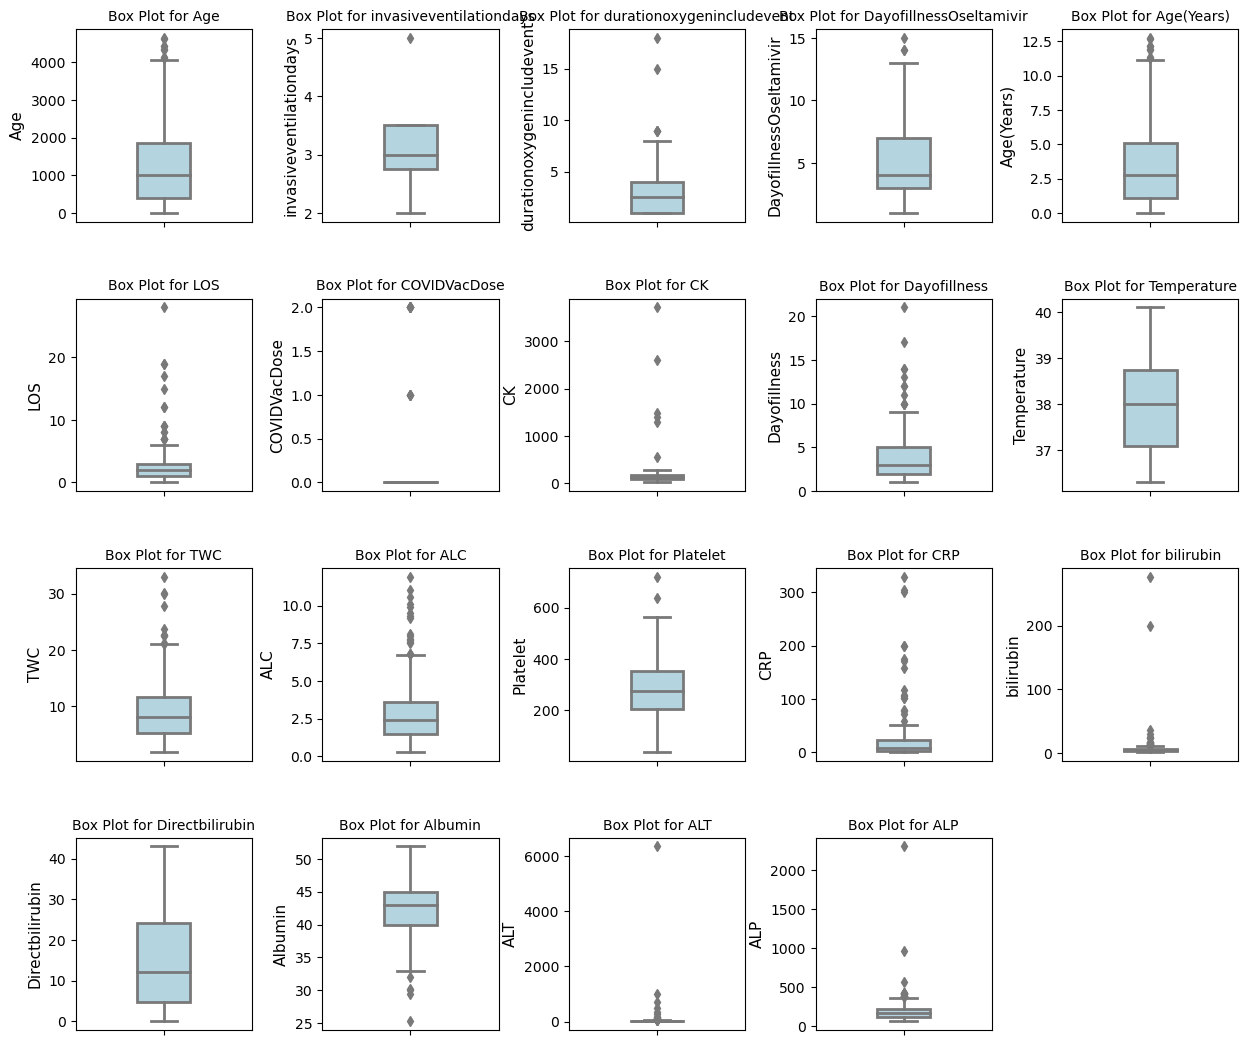

Age                          2.675585
invasiveventilationdays      0.334448
durationoxygenincludevent    1.672241
DayofillnessOseltamivir      1.003344
Age(Years)                   2.675585
LOS                          5.685619
COVIDVacDose                 3.344482
CK                           2.006689
Dayofillness                 3.678930
Temperature                  0.000000
TWC                          3.344482
ALC                          5.685619
Platelet                     0.668896
CRP                          5.685619
bilirubin                    6.354515
Directbilirubin              0.000000
Albumin                      1.672241
ALT                          7.357860
ALP                          4.682274
dtype: float64


In [4]:
## DATA PREPROCESSING ##
# check for duplicates
duplicates = df[df.duplicated()]
print(duplicates)

# check for outliers
cont_variables = df.columns[82:101]

# Create individual horizontal box plots for each continuous variable
plt.figure(figsize=(15, 20))
for i, column in enumerate(cont_variables, 1):
    plt.subplot(6, 5, i)
    sns.boxplot(y=df[column], width=0.3, color='lightblue', linewidth=2)
    plt.title(f'Box Plot for {column}', fontsize=10)
    plt.ylabel(column, fontsize=11)

# Adjust layout to prevent overlapping
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust the horizontal and vertical spacing
plt.show()

outlier_threshold = 1.5
# Calculate the percentage of outliers for each column
outliers_percentage = ((df[cont_variables] < df[cont_variables].quantile(0.25) - outlier_threshold * (df[cont_variables].quantile(0.75) - df[cont_variables].quantile(0.25))) |
                       (df[cont_variables] > df[cont_variables].quantile(0.75) + outlier_threshold * (df[cont_variables].quantile(0.75) - df[cont_variables].quantile(0.25)))).mean() * 100

print(outliers_percentage)

NOTE: 
no duplicates
16 out of 18 continouos variables with outliers 

In [5]:
# check for missing vales 
columns_to_check_missing = df.columns[6:101]

# Replace empty strings with NaN
df[columns_to_check_missing] = df[columns_to_check_missing].replace(r'^\s*$', np.nan, regex=True)

# Check for missing values
missing_values = df[columns_to_check_missing].isnull().sum()
percentage_missing = (missing_values / len(df)) * 100

print("\nPercentage Missing for Columns 6 to 100:\n", percentage_missing)


Percentage Missing for Columns 6 to 100:
 MaleSex             0.000000
Ethinicty           0.000000
Malay               0.000000
Chinese             0.000000
Indian              0.000000
                     ...    
bilirubin          37.458194
Directbilirubin    98.662207
Albumin            36.120401
ALT                35.117057
ALP                34.782609
Length: 95, dtype: float64


In [6]:
# address missingness
# Remove variables with missingness 50%
columns_to_remove_missingness = ['Directbilirubin', 'CK']
df_delete = df.drop(columns=columns_to_remove_missingness)

# imputations for missing values
# prepare dataset for MICE imputations
df_forMICE = df_delete.iloc[:, 6:99].copy()
# do not impute 
columns_to_drop = ['invasiveventilationdays', 'durationoxygenincludevent', 'DayofillnessOseltamivir']  
df_forMICE.drop(columns=columns_to_drop, inplace=True)

# Perform MICE imputation
huber_estimator = HuberRegressor()
imputer = IterativeImputer(
    random_state=43,
    sample_posterior=True,
    max_iter=10,
    tol=1e-3,
    n_nearest_features=5,
    verbose=True,
    #estimator=BayesianRidge(),
    imputation_order='ascending',
    skip_complete=True
)

df_imputed = pd.DataFrame(imputer.fit_transform(df_forMICE), columns=df_forMICE.columns)

# capped negative imputations
one_percentiles = {'TWC': 2.6, 'ALC': 0.578, 'Platelet': 65.4, 'CRP': 0.4, 'bilirubin': 2, 'Albumin': 29.946, 'ALT': 6, 'ALP': 67.9}  # Replace with your column names and respective lower bounds
# Cap values at 1percentile for negative imputed values
for col, one_percentile in one_percentiles.items():
    df_imputed[col] = np.maximum(df_imputed[col], one_percentile)

# Combine the imputed columns with the 'not to impute' columns
df_M = pd.concat([df_delete.iloc[:, :6], df_imputed, df_delete[columns_to_drop], df_delete.iloc[:, 99:]], axis=1)

# check missingness after MICE 
missing_values = df_M.isnull().sum()
percentage_missing_MICE = (missing_values / len(df_M)) * 100
print("\nPercentage Missing:\n", percentage_missing_MICE)

[IterativeImputer] Completing matrix with shape (299, 90)

Percentage Missing:
 ID                            0.000000
Dateofbirth                   0.000000
Dateofadmission               0.000000
Dateofdischarge               0.000000
diagnosis                     0.000000
                               ...    
ALT                           0.000000
ALP                           0.000000
invasiveventilationdays      98.662207
durationoxygenincludevent    68.561873
DayofillnessOseltamivir      40.133779
Length: 99, dtype: float64


NOTE:
a. remove variables direct bilirubin and CK as missingness was extreme, not suitable for imputation
b. multiple imputation chain equation (MICE) as mulitple imputations for variables with missing values 

Stats Summary with Percentiles, Lower, Upper Bounds, 0.01th, and 99.8th Percentiles:
              count        mean         std        min         1%         25%  \
Age(Years)    299.0    3.521354    3.016977   0.016438   0.071123    1.080822   
LOS           299.0    2.581940    2.940542   0.000000   0.000000    1.000000   
COVIDVacDose  299.0    0.053512    0.301806   0.000000   0.000000    0.000000   
Dayofillness  299.0    4.073579    2.810802   1.000000   1.000000    2.000000   
Temperature   299.0   37.995987    0.955126  36.300000  36.300000   37.100000   
TWC           299.0    9.305242    5.127958   2.600000   2.600000    5.350000   
ALC           299.0    2.990418    2.027980   0.578000   0.578000    1.500000   
Platelet      299.0  281.093035  107.309008  65.400000  67.948000  209.500000   
CRP           299.0   30.901335   48.072654   0.400000   0.400000    0.500000   
bilirubin     299.0   10.871082   21.940347   2.000000   2.000000    3.000000   
Albumin       299.0   42

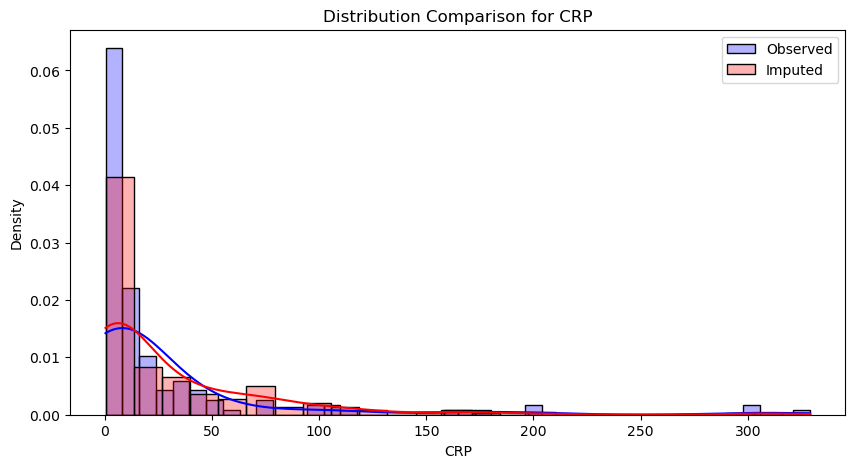

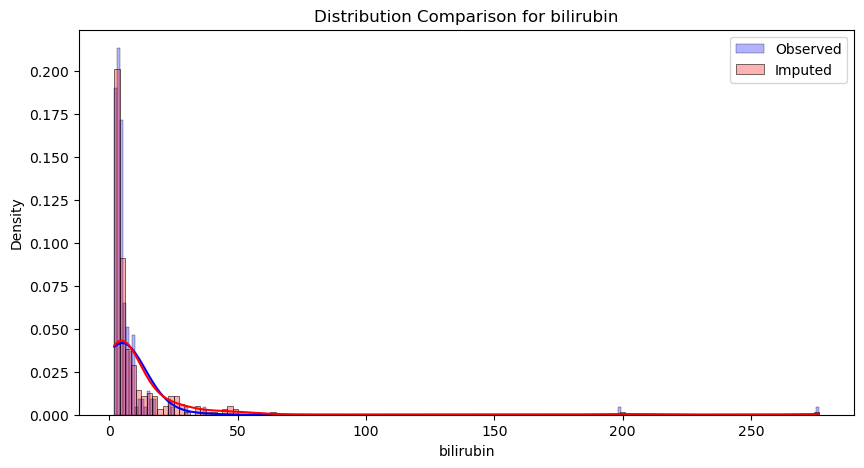

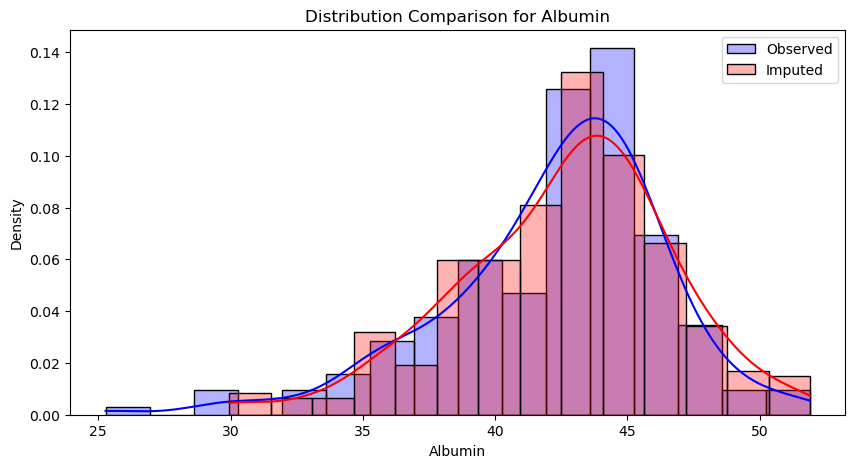

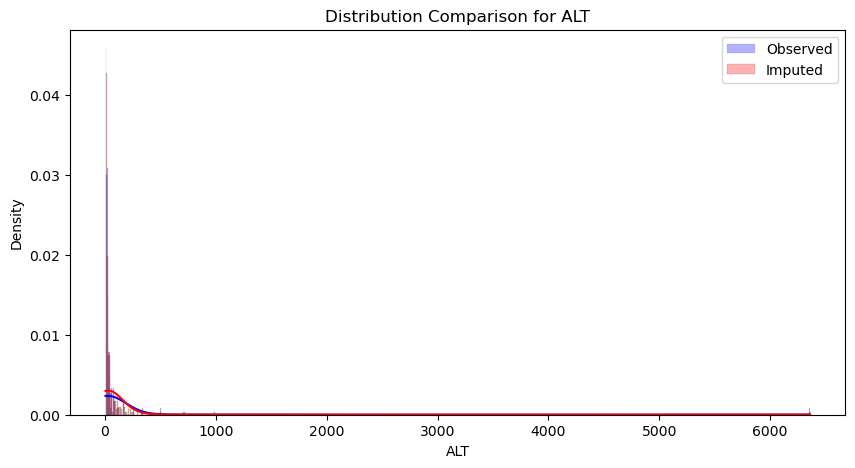

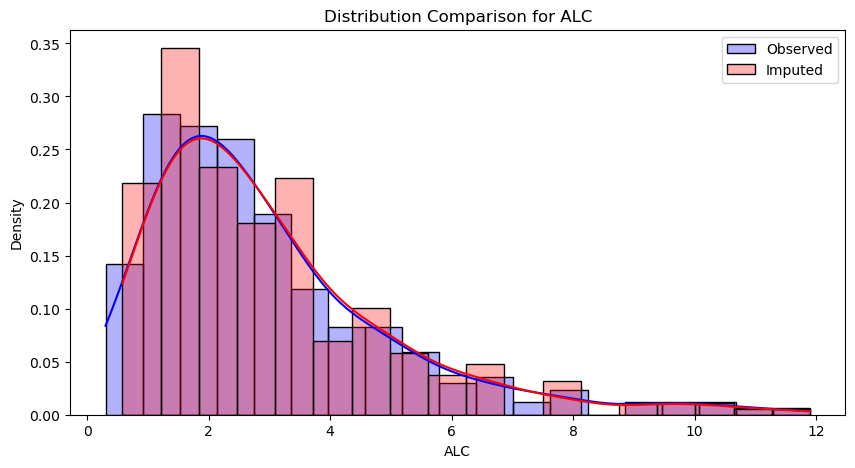

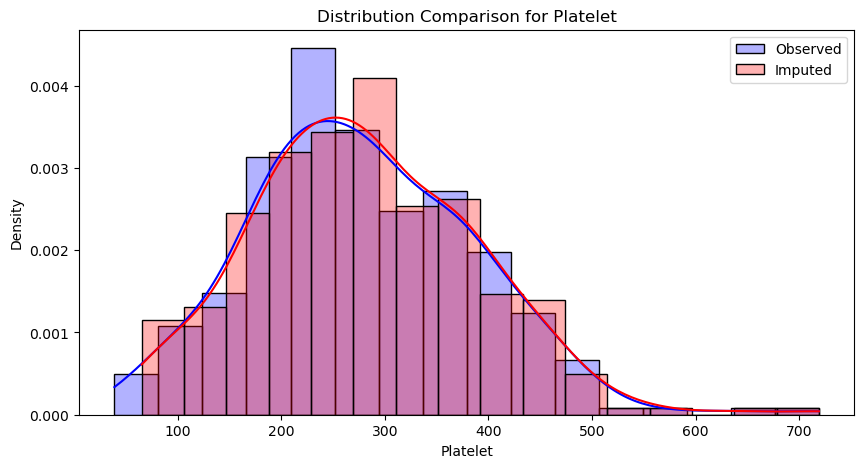

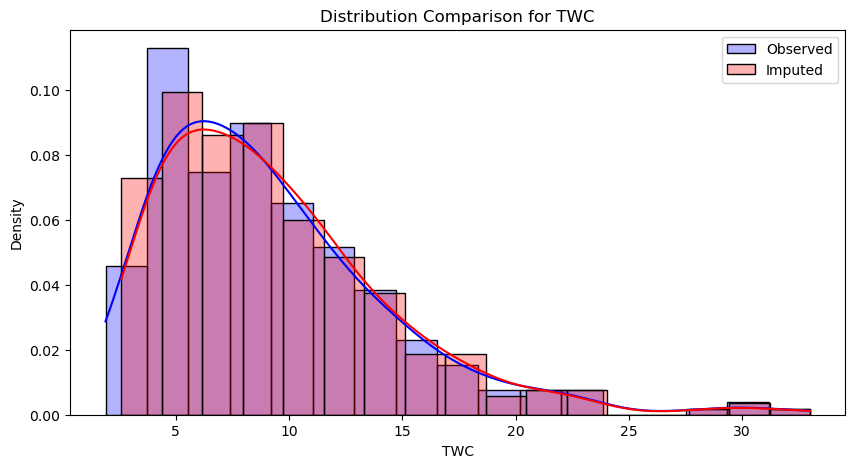

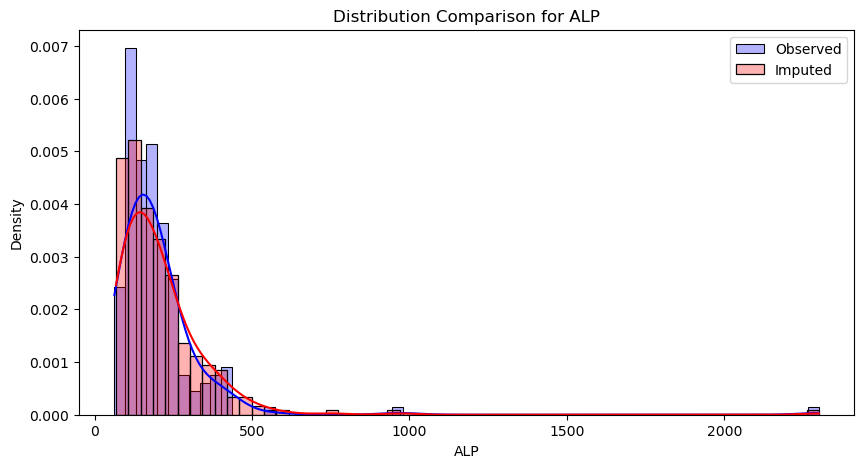

In [7]:
# diagnostics post-imputations
# stats summary for continous variables (after imputation)
selected_columns_imputed = df_M.iloc[:, 83:96]

# Calculate percentiles, lower, upper bounds, 0.01th, and 99.98th percentiles
percentiles_imputed = selected_columns_imputed.describe(percentiles=[0.25, 0.5, 0.75, 0.01, 0.998]).transpose()

# Calculate lower and upper bounds
IQR = percentiles_imputed['75%'] - percentiles_imputed['25%']
lower_bound = percentiles_imputed['25%'] - 1.5 * IQR
upper_bound = percentiles_imputed['75%'] + 1.5 * IQR

# Add lower and upper bounds to the percentiles DataFrame
percentiles_imputed['lower_bound'] = lower_bound
percentiles_imputed['upper_bound'] = upper_bound

# Display the result
print("Stats Summary with Percentiles, Lower, Upper Bounds, 0.01th, and 99.8th Percentiles:")
print(percentiles_imputed)

# Loop over each variable to generate individual plots
variables = ["CRP", "bilirubin", "Albumin", "ALT", "ALC", "Platelet", "TWC", "ALP"]

for var in variables:
    # Extract observed values from the original dataset (df_delete)
    observed = df[var].dropna()
    
    # Extract imputed values from df_M at indices where the original dataset was missing
    imputed = df_M[var].dropna()
    
    plt.figure(figsize=(10, 5))
    sns.histplot(observed, color='blue', label='Observed', kde=True, stat="density", alpha=0.3)
    sns.histplot(imputed, color='red', label='Imputed', kde=True, stat="density", alpha=0.3)
    plt.title(f"Distribution Comparison for {var}")
    plt.legend()
    plt.show()

Kolmogorov–Smirnov test for Age(Years): p-value = 0.000
Kolmogorov–Smirnov test for LOS: p-value = 0.000
Kolmogorov–Smirnov test for COVIDVacDose: p-value = 0.000
Kolmogorov–Smirnov test for Dayofillness: p-value = 0.000
Kolmogorov–Smirnov test for Temperature: p-value = 0.000
Kolmogorov–Smirnov test for TWC: p-value = 0.000
Kolmogorov–Smirnov test for ALC: p-value = 0.000
Kolmogorov–Smirnov test for Platelet: p-value = 0.000
Kolmogorov–Smirnov test for CRP: p-value = 0.000
Kolmogorov–Smirnov test for bilirubin: p-value = 0.000
Kolmogorov–Smirnov test for Albumin: p-value = 0.000
Kolmogorov–Smirnov test for ALT: p-value = 0.000
Kolmogorov–Smirnov test for ALP: p-value = 0.000
Kolmogorov–Smirnov test for invasiveventilationdays: p-value = 0.000
Kolmogorov–Smirnov test for durationoxygenincludevent: p-value = 0.000
Kolmogorov–Smirnov test for DayofillnessOseltamivir: p-value = 0.000


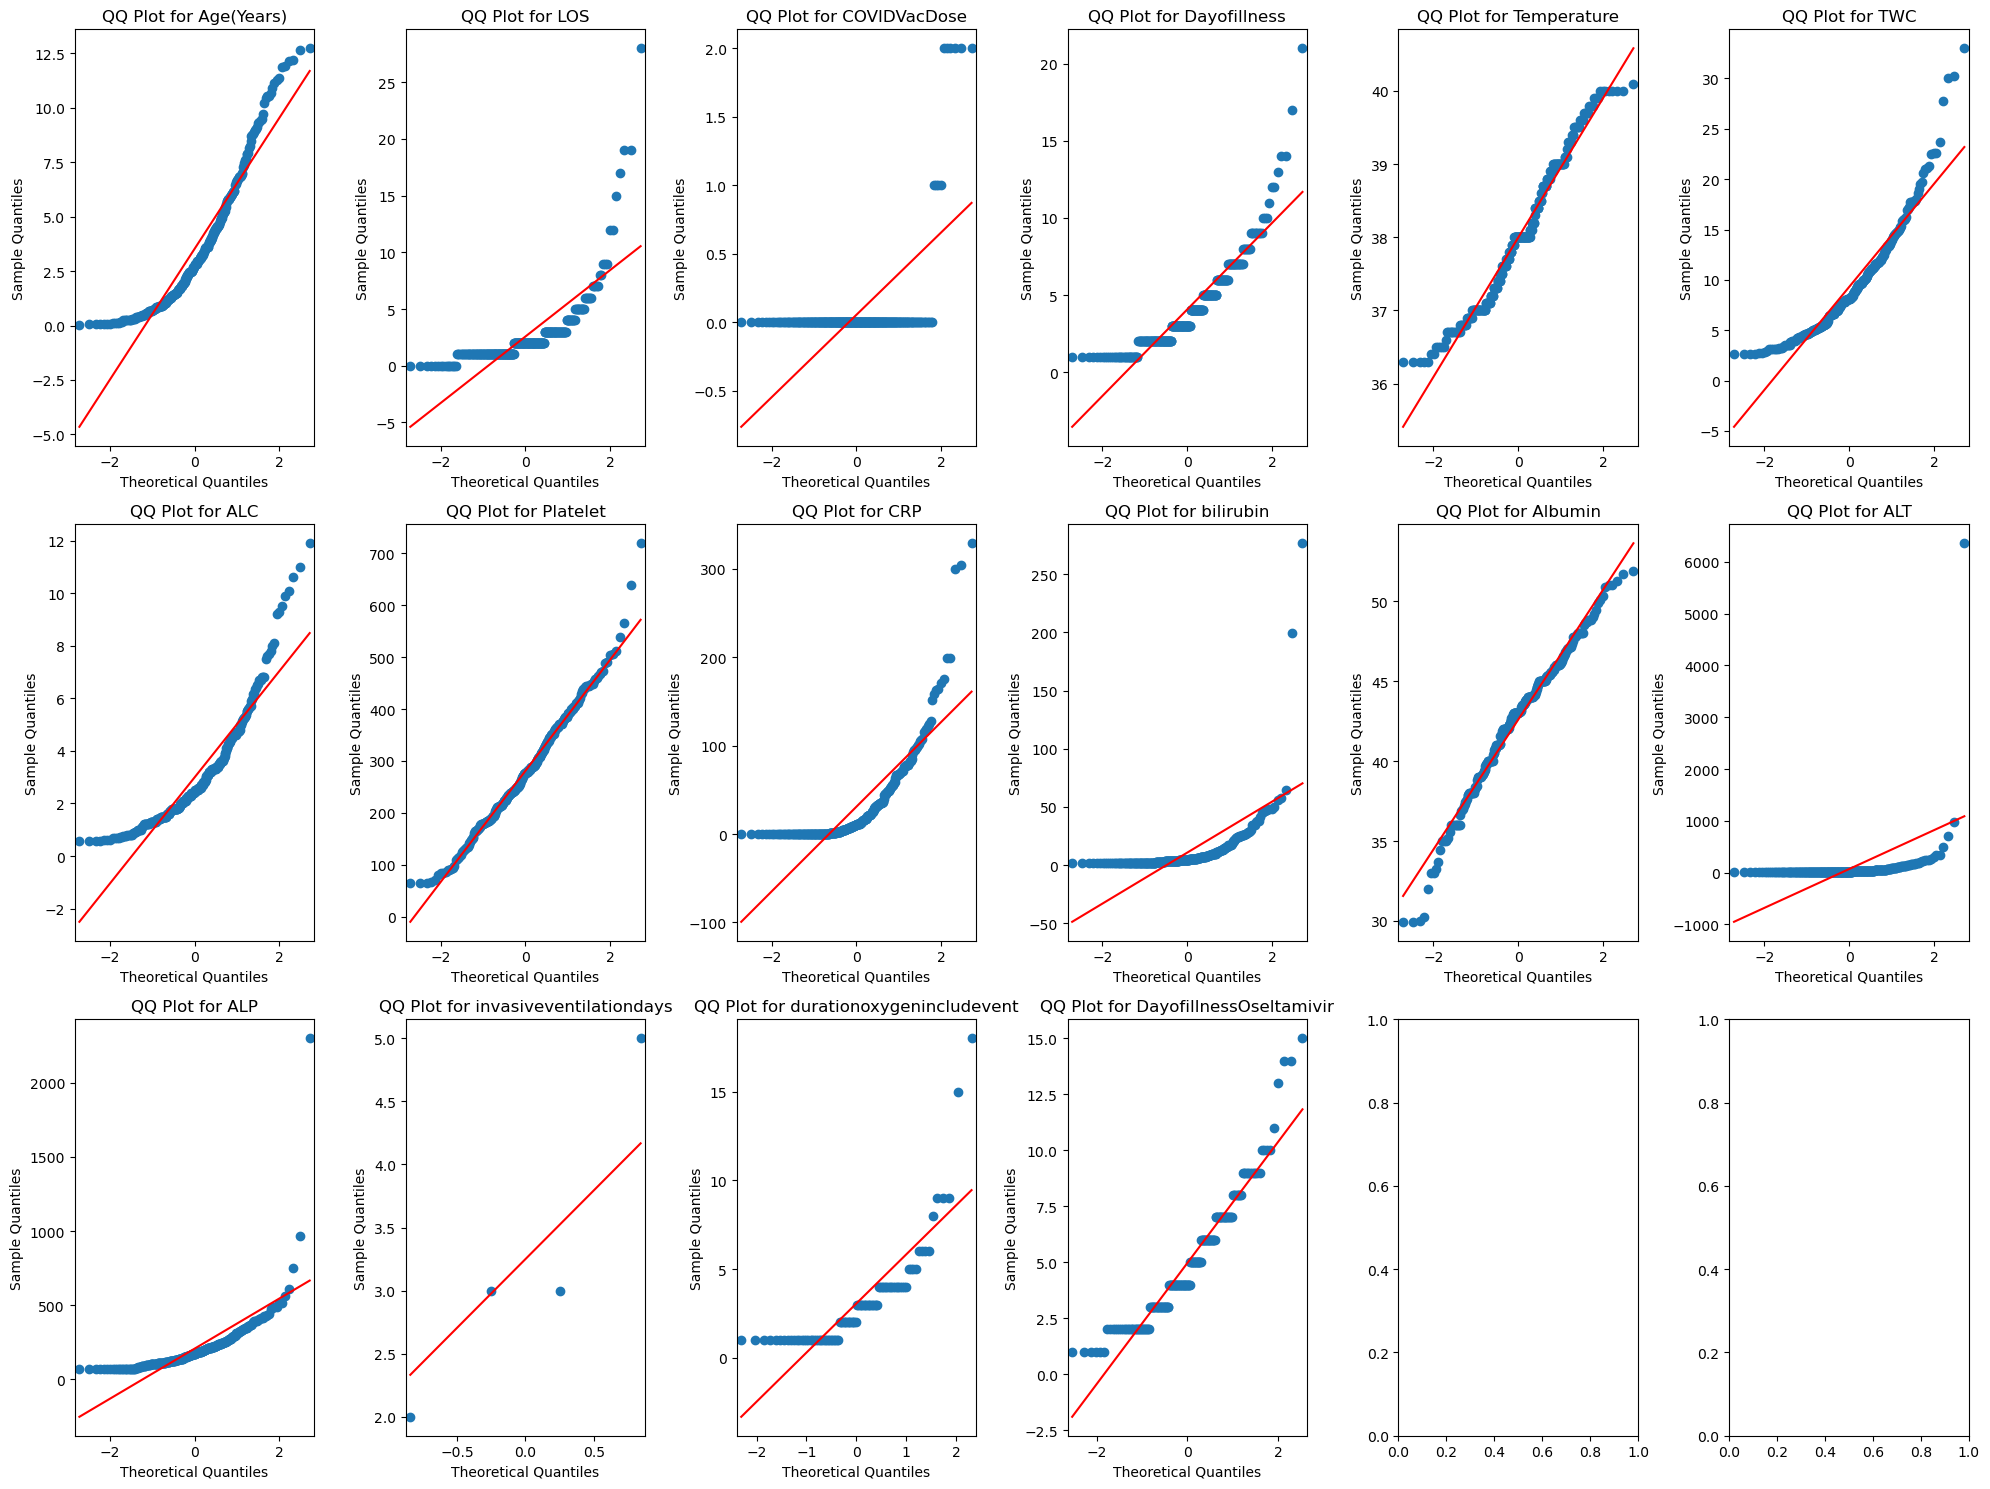

In [8]:
# Normality Assesment
# Check normality using Kolmogorov–Smirnov test and QQ plot

cont_variables_df_M = df_M.columns[83:99]

for column in cont_variables_df_M:
    # Exclude missing values before conducting tests
    data = df_M[column].dropna()

    # Kolmogorov–Smirnov test
    kstest_result = stats.kstest(data, 'norm')
    p_value_formatted = "{:.3f}".format(kstest_result.pvalue)
    print(f'Kolmogorov–Smirnov test for {column}: p-value = {p_value_formatted}')
    
# Combine QQ plots into subplots
num_plots = len(cont_variables_df_M)
num_cols = 6
num_rows = (num_plots + num_cols - 1) // num_cols  # Adjust to include the last row

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 15))

for i, column in enumerate(cont_variables_df_M):
    row = i // num_cols
    col = i % num_cols

    # QQ plot
    sm.qqplot(df_M[column].dropna(), line='s', ax=axes[row, col])
    axes[row, col].set_title(f'QQ Plot for {column}')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

NOTES:
all 18 continuous variables had non-normal distributions
as Kolmogorov–Smirnov test p-values were all < 0.05 and QQplots were not linear 

In [9]:
# Save processed dataset
df_processed = df_M.iloc[:, 6:99].copy()

# save as csv file
# csv_file_path = r'E:/1 PROJECT/RESEARCH PROJECTS/HTJ res/influenza/Data/FluCovid_processedData.csv'
# df_processed.to_csv(csv_file_path, index=False)

# save as csv excel file
# excel_file_path = r'E:/1 PROJECT/RESEARCH PROJECTS/HTJ res/influenza/Data/FluCovid_processedData.xlsx'
# df_processed.to_excel(excel_file_path, index=False)